# PyTorch MNIST digits training

https://nextjournal.com/gkoehler/pytorch-mnist
https://github.com/pytorch/examples/blob/master/mnist/main.py
https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [1]:
import torch
import torchvision

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
import numpy as np

In [5]:
from pathlib import Path

In [6]:
from PIL import Image

In [7]:
from torchvision import datasets, transforms

In [8]:
n_epochs = 10

In [9]:
batch_size_train = 64
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
# torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              ])

In [11]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform),
  batch_size=batch_size_train, shuffle=True)

In [12]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform),
  batch_size=batch_size_test, shuffle=True)

In [13]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([10000, 1, 28, 28])

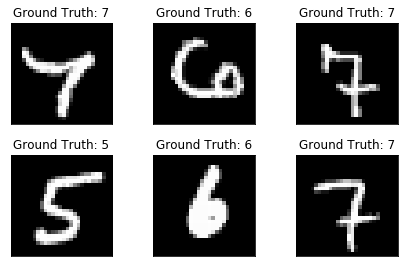

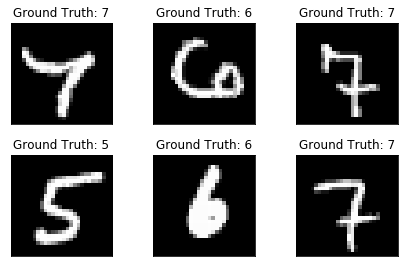

In [14]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [16]:
network = Net()
optimizer = optim.SGD(network.parameters(),
                      lr=learning_rate,
                      momentum=momentum)

In [17]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

In [18]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) +
                                 ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

In [19]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [20]:
test()


Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)



E:\py\pytorch\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
E:\py\pytorch\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [21]:
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

E:\py\pytorch\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268458
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.839604
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.927138
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.932272
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.772578
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.727685
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.722906
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.593229
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.801043
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.337982

Test set: Avg. loss: 0.1989, Accuracy: 9439/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.540850
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.509392
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.400315
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.481171
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.465868
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.448811
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.211114
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.461171
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.428354
Trai

In [22]:
epoch_ends = np.arange(0, n_epochs + 1) * 60000

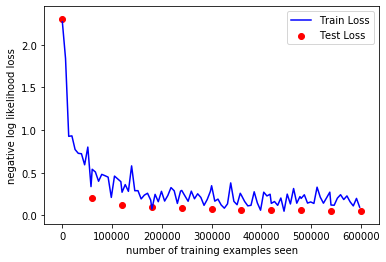

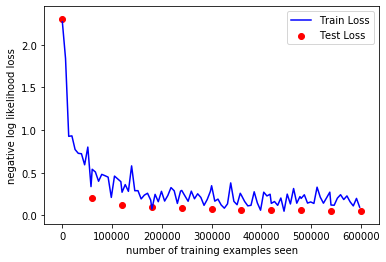

In [23]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(epoch_ends, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [24]:
image_path = Path(r'C:\Users\b_r_l\source\repos\sudoku\images')

images = [*image_path.glob('*-cv2.png')]
images

[WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_0-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_1-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_2-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_3-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_4-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_5-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_6-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_7-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/0_8-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/1_0-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/1_1-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/1_2-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/1_3-cv2.png'),
 WindowsPath('C:/Users/b_r_l/source/repos/sudoku/images/1_4-cv2.png'),
 Windo

In [30]:
imgs = []
for image in images:
    img = Image.open(image)
    img = img \
      .convert('L') \
        .crop((7, 6, 56, 56)) \
          .resize((28, 28))
    a = 1 - (np.array(img) / 255)
    if a.sum() > 0:
        a = (a - 0.1307) / 0.3081
        a = a.reshape((1, 28, 28))
        a = a.astype(np.double)
        img.save(image_path / '28' / (image.stem + '_28.png'))
        imgs.append(a)
len(imgs)

26

In [31]:
with torch.no_grad():
    t = torch.tensor(imgs).float()
    output = network(t)

E:\py\pytorch\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


6


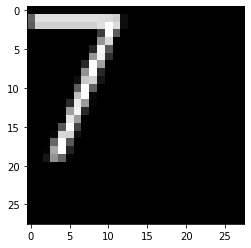

9


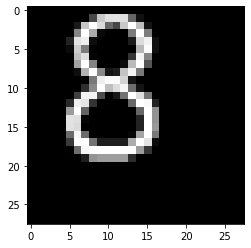

2


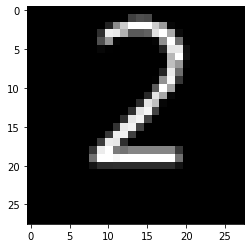

6


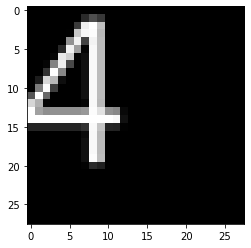

1


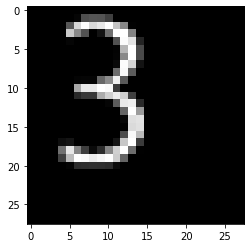

2


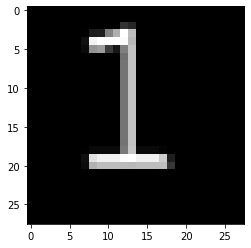

3


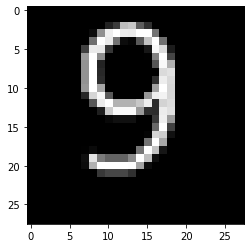

5


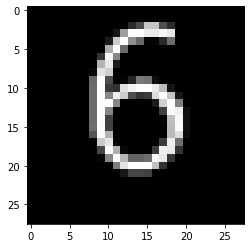

4


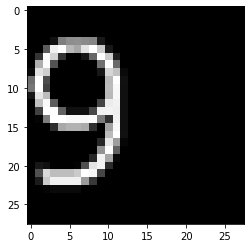

4


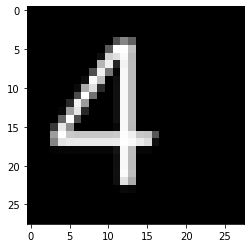

1


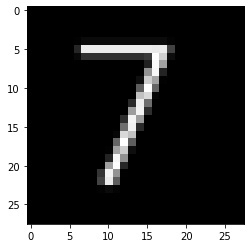

1


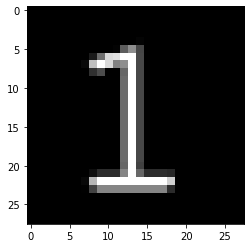

4


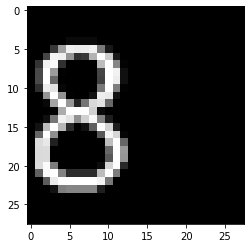

5


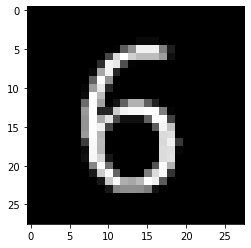

5


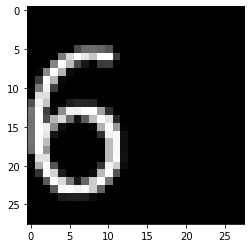

4


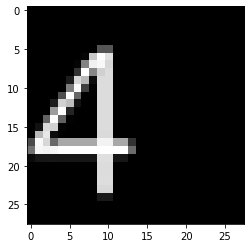

2


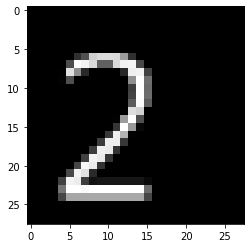

5


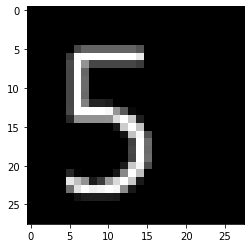

9


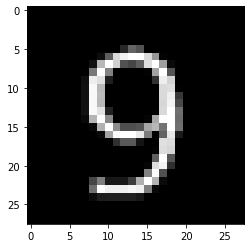

5


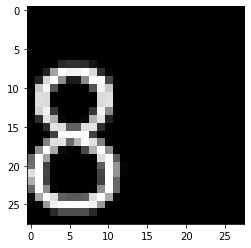

8


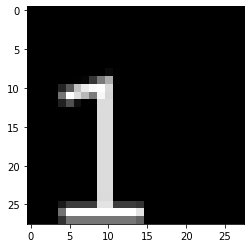

9


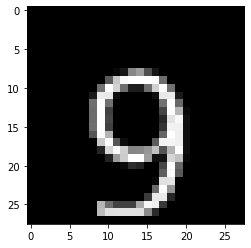

8


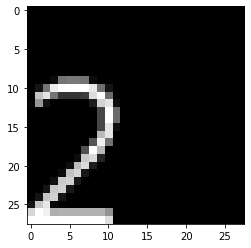

0


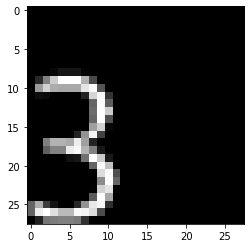

9


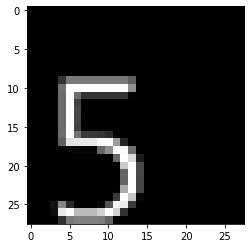

7


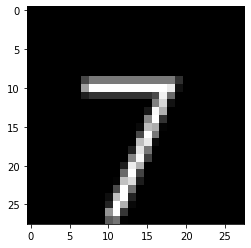

In [32]:
for i in range(len(output)):
    print(output.data.max(1, keepdim=True)[1][i].item())
    plt.imshow(imgs[i].reshape(28,28), cmap="gray")
    plt.show()